<a href="https://colab.research.google.com/github/fpakpour/FatemehRep/blob/master/Copy_of_Delay_Last_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
import glob
# import imageio
import json
import os
import cv2
import itertools 
from tqdm import tqdm
# from scipy.special import gammainc
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits import mplot3d
from numba import njit
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
Dt=20
N=10000
L0=10.0
rho=np.round(N/(L0**3),2)
v0=0.1
r=1.0
# r_rep=0
# r_att=0
# c_align=1.0
# c_rep=0.1
# c_att=0
eta=0.02
q=1
dt=1.0
T=1000
# strict=False
# VEM=True
# CHM=False
# DHM=False
# SHM=False
# DHMZ=False
# SHMZ=False

txt_VEM='VEM, Preiodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)+', q='+str(q)+', Delay='+str(Dt)+' time steps'
# txt_CHM='CHM, Periodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)
# txt_DHM='DHM, Periodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)
# txt_SHM='SHM, Preiodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)+', q='+str(q)
# txt_DHMZ='DHMZ, Preiodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)+', q='+str(q)
# txt_SHMZ='SHMZ, Preiodic_BC, N='+str(N)+', L='+str(L0)+', T='+str(T)+', rho='+str(rho)+', r='+str(r)+', v0='+str(v0)+', eta='+str(eta)+', q='+str(q)

In [ ]:
center = np.array([0,0,0])
U_av=np.zeros((T,N,3))
#t_start=np.random.randint(low=5, high=20, size=(N))

#Defining particles initial positions
X=np.random.uniform(low=0, high=L0, size=(N,3))

#Defining particles initial velocity vectors
U=np.random.normal(0,1.0, size=(N,3))

#Normalization of the velocity vectors to the magnitude of the velocity(v0)
norm_U=np.sqrt(np.sum(U**2, axis=1)).reshape(N,1)
U=v0*U/norm_U

<function matplotlib.pyplot.close>

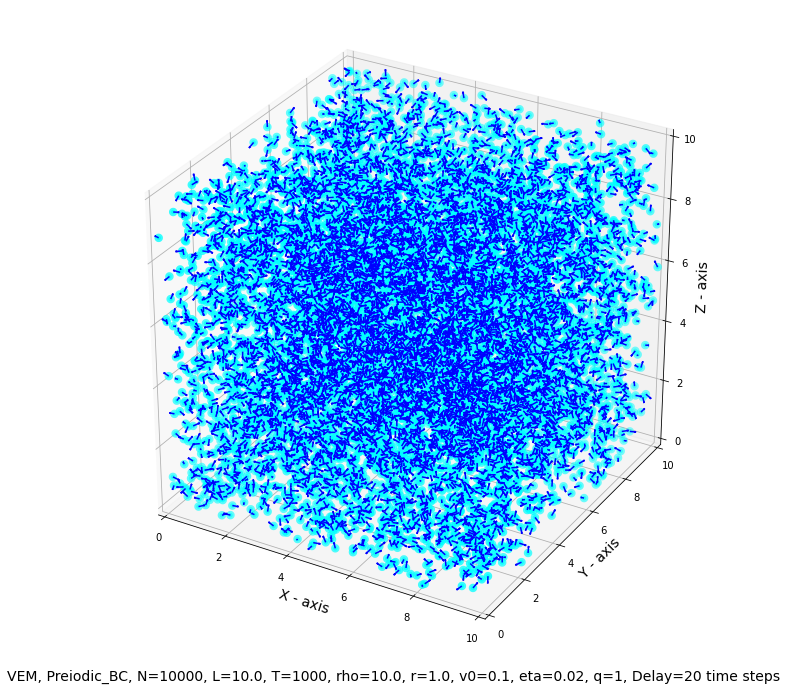

In [ ]:
# fig = plt.figure(figsize=[12,12])
# ax = fig.add_subplot(projection='3d')
# #ax.view_init(0, 180) #this is used for changing the view

# ax.set_xlabel('X - axis', fontsize=14)
# ax.set_ylabel('Y - axis', fontsize=14)
# ax.set_zlabel('Z - axis', fontsize=14)

# ax.scatter(X[:,0],X[:,1],X[:,2], linewidths=4, color='cyan')

# #Ploting velocity vectors
# ax.quiver(X[:,0],X[:,1],X[:,2], 2*U[:,0],2*U[:,1],2*U[:,2], color='blue')

# #Caption of the video
# fig.text(.5, .1, txt_VEM, ha='center',fontsize=14, linespacing=0.1)

# plt.xlim(0,L0)
# plt.ylim(0,L0)
# ax.set_zlim3d([0,L0])

# #Saving first frame in a file
# plt.savefig('/content/drive/My Drive/Flock3D_PBC_Delay/VEM_frames/frame_VEM0.png') 
# plt.close

In [ ]:
#Order parameter data initializing
data_order_p=np.zeros((T,3))
Sum_U=np.zeros((1,3))
    
for j in range(3):
    for i in range(N):
        Sum_U[0,j] += U[i,j]
        
order_p = np.abs(Sum_U/N)/v0

data_order_p[0]=order_p


In [ ]:
#Calculation of the order parameter
def order_parameter(U_align):
    Sum_U=np.zeros((1,3))
    
    for j in range(3):
        for i in range(N):
            Sum_U[0,j] += U_align[i,j]
               
    order_p = np.abs(Sum_U/N)/v0
    
    return order_p

In [ ]:
def noise_vector(center, eta, N): 
    
    ndim = center.size
    X_noise = np.random.normal(size=(N, ndim))
    Xsq = np.sum(X_noise**2,axis=1)
    fr = eta*sc.gammainc(ndim/2,Xsq/2)**(1/ndim)/np.sqrt(Xsq)
    frtiled = np.tile(fr.reshape(N,1),(1,ndim))
    noise = center + np.multiply(X_noise,frtiled)
    return noise

In [ ]:
#Calculation of noise
# def noise_vector(eta, N):
#     noise=np.zeros((N,3))
#     noise=np.random.normal(0,1.0, size=(N,3))
#     norm_noise=np.sqrt(np.sum(noise**2, axis=1)).reshape(N,1)
#     noise=eta*noise/norm_noise
#     return noise

In [ ]:
@njit()
def update_A(data):
    A = np.zeros((N,N))
    n = np.zeros(N)
    for i in range(N):
        for j in range(i,N):
            dx=data[i,0]-data[j,0]
            dy=data[i,1]-data[j,1]
            dz=data[i,2]-data[j,2]
            distance = np.sqrt( dx**2 + dy**2 +dz**2 )
            if distance <= r:
                A[i,j] = 1
                A[j,i] = 1
                n[i]+=1
    return A, n

In [ ]:
#Ploting

def Simulation_plot(k, X, U_align):
    fig = plt.figure(figsize=[12,12])
    ax = fig.add_subplot(projection='3d')
    # #ax.view_init(0, 180)  
    ax.set_xlabel('X - axis', fontsize=14)
    ax.set_ylabel('Y - axis', fontsize=14)
    ax.set_zlabel('Z - axis', fontsize=14)
    
    ax.scatter(X[:,0],X[:,1],X[:,2], linewidths=4, color='cyan')
 
    ax.quiver(X[:,0],X[:,1],X[:,2], 2*U_align[:,0], 2*U_align[:,1], 2*U_align[:,2],color='blue')

         
    fig.text(.5, .1, txt_VEM, ha='center',fontsize=14, linespacing=0.1)
  
    
    plt.xlim(0,L0)
    plt.ylim(0,L0)
    ax.set_zlim3d(0,L0)
   
    plt.savefig('/content/drive/My Drive/Flock3D_PBC_Delay/VEM_frames/frame_VEM'+str(k+1)+'.png')
        
    plt.close()   

In [ ]:
# @njit()
# def U_average(noise, N, k, t_start):
#   norm_Uav=np.zeros(N)
#   for i in range(N):
#     j = k-t_start[i]
#     U_av[j,i,:]=U_av[j,i,:]+ noise[i]
#     norm_Uav[i]=np.sqrt(np.sum(U_av[j,i,:]**2, axis=0))
#     U_align[i,:] = v0*U_av[j,i,:]/norm_Uav[i]

#   return U_align

In [ ]:
#Definition of C and B matrices

C = np.ones((N,N))*q
B = np.ones((N,N))


for k in tqdm(range(Dt)): #(Dt)):
    

    A, n = update_A(X)
    L = np.zeros((N,N))        
    Ds = np.zeros((N,N))    
    
    L = C*B*A

    ntiled = np.tile(n.reshape(N,1),(1,3))

    U_av[k,:,:] = (1/ntiled)*np.matmul(L,U)


    noise = noise_vector( center,eta, N) 
    U = U + noise
 
    norm_U = np.sqrt(np.sum(U**2, axis=1))
    norm_Utiled = np.tile(norm_U.reshape(N,1),(1,3))
    U_align = v0*U/norm_Utiled

    
#Updating particles positions
    X = X + U_align*dt 
        
#Applying periodic boundary conditions. X%Lo gives the remainder after dividing X by L0
    X = X%L0

#Updating velocities
    U = U_align
      
#Ploting
    #Simulation_plot(k,X,U_align)

    order_p=order_parameter(U_align)
    data_order_p[k]=order_p 
    


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


In [ ]:
t_start=np.random.randint(low=5, high=20, size=(N))
for k in tqdm(range(Dt, T-1)):

    A, n = update_A(X)
    L = np.zeros((N,N))        
    Ds = np.zeros((N,N))
    
    
    L = C*B*A
    
    ntiled = np.tile(n.reshape(N,1),(1,3))
    U_av[k,:,:] = (1/ntiled)*np.matmul(L,U)

    
    noise = noise_vector(center, eta, N)


    norm_Uav=np.zeros(N)
    for i in range(N):
      j = k-t_start[i]
      U_av[j,i,:]=U_av[j,i,:]+ noise[i]
      norm_Uav[i]=np.sqrt(np.sum(U_av[j,i,:]**2, axis=0))
      U_align[i,:] = v0*U_av[j,i,:]/norm_Uav[i]

    
#Updating particles positions
    X = X + U_align*dt

#Applying periodic boundary conditions. X%Lo gives the remainder after dividing X by L0
    X = X%L0
        
#Updating velocities
    U = U_align

    
#Ploting
    #Simulation_plot(k,X,U_align)
    
#Calculation of the order parameter 
    
    order_p = order_parameter(U_align)
    data_order_p[k]=order_p 

100%|██████████| 979/979 [25:42<00:00,  1.58s/it]


In [ ]:
#Save order parameters components in the files
np.savetxt('/content/drive/My Drive/Flock3D_PBC_Delay/OP_data/op_VEM_x_'+str(N)+'_D'+str(Dt)+'_n'+str(eta)+'.txt', data_order_p[:,0]) 
np.savetxt('/content/drive/My Drive/Flock3D_PBC_Delay/OP_data/op_VEM_x_'+str(N)+'_D'+str(Dt)+'_n'+str(eta)+'.txt', data_order_p[:,1]) 
np.savetxt('/content/drive/My Drive/Flock3D_PBC_Delay/OP_data/op_VEM_x_'+str(N)+'_D'+str(Dt)+'_n'+str(eta)+'.txt', data_order_p[:,2])


In [ ]:
# image_folder = '/content/drive/My Drive/Flock3D_PBC_Delay/VEM_frames'
# video_name = '/content/drive/My Drive/Flock3D_PBC_Delay/video/VEM'+str(N)+'_D'+str(Dt)+'_n'+str(eta)+'.avi'
# images=['frame_VEM'+str(k)+'.png' for k in range(T-1)]
   
# frame=cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape
# video = cv2.VideoWriter(video_name, 0, 15, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()

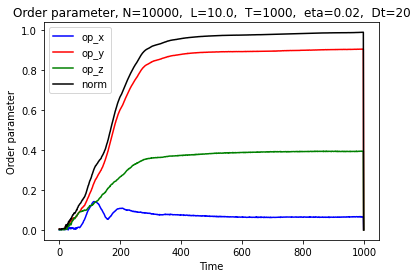

In [ ]:
x = np.arange(0,T)
y1 = data_order_p[:,0]
y2 = data_order_p[:,1]
y3 = data_order_p[:,2]
plt.title("Order parameter, N="+str(N)+",  L="+ str(L0)+ ",  T="+str(T)+",  eta="+str(eta)+",  Dt="+str(Dt))
plt.ylabel("Order parameter") 
plt.xlabel("Time") 
plt.plot(x, y1, 'b', label='op_x')
plt.plot(x, y2, 'r', label='op_y')
plt.plot(x, y3, 'g', label='op_z')
plt.plot(x, np.sqrt(y1**2 + y2**2+ y3**2), 'k', label='norm')

plt.legend()
plt.show()

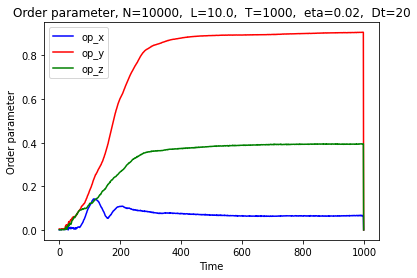

In [ ]:
x = np.arange(0,T)
y1 = data_order_p[:,0]
y2 = data_order_p[:,1]
y3 = data_order_p[:,2]
plt.title("Order parameter, N="+str(N)+",  L="+ str(L0)+ ",  T="+str(T)+",  eta="+str(eta)+",  Dt="+str(Dt))
plt.ylabel("Order parameter") 
plt.xlabel("Time") 
plt.plot(x, y1, 'b', label='op_x')
plt.plot(x, y2, 'r', label='op_y')
plt.plot(x, y3, 'g', label='op_z')
plt.legend()
plt.show()